In [28]:
!pip install langchain_core langgraph streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 118.7 MB/s eta 0:00:00


In [2]:
from typing import TypedDict, List, Dict, Union
from langchain_core.messages import HumanMessage, AIMessage
# from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
# from dotenv import load_dotenv
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch
import numpy as np
import pandas as pd

from google.colab import userdata
HF_TOKEN = userdata.get("HF_TOKEN")


In [4]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"

generator = pipeline(
    "text-generation",
    model=model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    token=HF_TOKEN
)



config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Device set to use cpu


In [73]:
import sqlite3



def get_patient_info(patient_id):
  # conn = sqlite3.connect("patient_clients.db")
  # cursor = conn.cursor()

  # cursor.execute("SELECT * FROM bio WHERE patient_id = 'patient_id', (50,) ")
  # row = cursor.fetchall()
  row = "35 year old Male"

  # conn.close()
  return row




latest_patient_response = []
current_question = []
counter = 0
patient_id = [1]

class AgentState(TypedDict):
  messages: List[Dict]
  running_notes: str
  current_question: str
  patient_response: str
  system_questions: List[Dict]
  differentials_list: str
  # more_info: bool

def get_profile_info(state: AgentState)->AgentState:
  """This function is a node that gets the patient demographic information and medical history from the database."""
  pt_info = get_patient_info(patient_id[0])
  state['messages'].append({"role":"user", "content":pt_info})
  state['running_notes'] = pt_info
  return state




def decide_questions_to_ask(state: AgentState)->AgentState:
  """This function decides which question to ask using an LLM"""
  response = generator(state['messages'], max_new_tokens=256)[0]["generated_text"][-1]["content"]
  state['system_questions'].append({response})
  state['current_question'] = response
  return state


def ask_question_get_answer(state: AgentState)->AgentState:
  """This funtion asks the questions to the patient and gets the answers"""
  # patient_response = st.text_area("Write you answers here:", height=180, placeholder="Your answers here: ")
  # latest_patient_response.append(patient_response)
  if len(latest_patient_response)>0:
    state['patient_response'] = latest_patient_response[-1]
    latest_patient_response.pop(0)
  return state


def compile_notes(state: AgentState)->AgentState:
  """This combines the current medical history available in the current notes with the answer that the patient has just provided"""
  compile_notes_prompt = f"As an expert physician that pays attention to detail. Combine the following history {state['running_notes']} and these answers {state['patient_response']} provided by the patient to these questions {state['current_question']}"
  state['running_notes'] = generator([{"role":"user", "content": compile_notes_prompt}], max_new_tokens=256)[0]["generated_text"][-1]["content"]
  return state


def is_more_info_needed(state: AgentState)->bool:
  """Decide if this info is needed to be able to make a good plan for the patient"""
  global counter
  prompt_full_history = f"Answer with 'Yes' or 'No' only. Is this medical history detailed enough to make a good differential diagnosis and then a plan? {state['running_notes']}"
  if counter > 5:
    return "No"
  else:
    counter += 1
    decision = generator([{"role":"user", "content": prompt_full_history}], max_new_tokens=256)[0]["generated_text"][-1]["content"]
    print(f"This is the decision on whether more information is needed: {decision}")
    if decision.lower() is True:
      return "Yes"
    else:
      return "No"

def list_possible_differentials(state: AgentState)->AgentState:
  """This function creates a list of differential diagnosis based on the list"""
  system_prompt_for_differential = f"You are an expert physician, you have to provide a differential diagnosis for the provided medical history"
  user_prompt_for_differential = state['running_notes']
  state['differentials_list'] = generator([{"role": "system", "content":system_prompt_for_differential},{"role":"user", "content":user_prompt_for_differential}], max_new_tokens=256)[0]["generated_text"][-1]["content"]
  return state


def create_plan(state: AgentState)->AgentState:
  # Need RAG with a directory of physicians
  """This function creates a plan based on the history and the differential diagnosis list"""
  system_prompt_for_plan = f"You have to provide medical advise to this individual. Always insist that the patient needs to seek medical advice. Advise which specialty the patient needs to see. Do not provide definitive medical treatment but suggest what the patient should expect when they go to see a physician"
  user_prompt_for_plan = state['running_notes'] + state["differentials_list"]
  state['plan'] = generator([{"role": "system", "content":system_prompt_for_plan},{"role":"user", "content":user_prompt_for_plan}], max_new_tokens=256)[0]["generated_text"][-1]["content"]
  return state

graph = StateGraph(AgentState)
graph.add_node("get_profile_info", get_profile_info)
graph.add_node("decide_questions_to_ask", decide_questions_to_ask)
graph.add_node("ask_question_get_answer", ask_question_get_answer)
graph.add_node("compile_notes", compile_notes)
graph.add_node("is_more_info_needed", lambda state:state)
graph.add_node("list_possible_differentials", list_possible_differentials)
graph.add_node("create_plan", create_plan)


graph.add_edge(START, "get_profile_info")
graph.add_edge("get_profile_info", "decide_questions_to_ask")
graph.add_edge("decide_questions_to_ask", "ask_question_get_answer")
graph.add_edge("ask_question_get_answer", "compile_notes")
graph.add_edge("compile_notes", "is_more_info_needed")
graph.add_conditional_edges(
    "is_more_info_needed",
    is_more_info_needed,
    {
       "Yes": "decide_questions_to_ask",
       "No": "list_possible_differentials",
    }
)

graph.add_edge("list_possible_differentials", "create_plan")
graph.add_edge("create_plan", END)
agent = graph.compile()





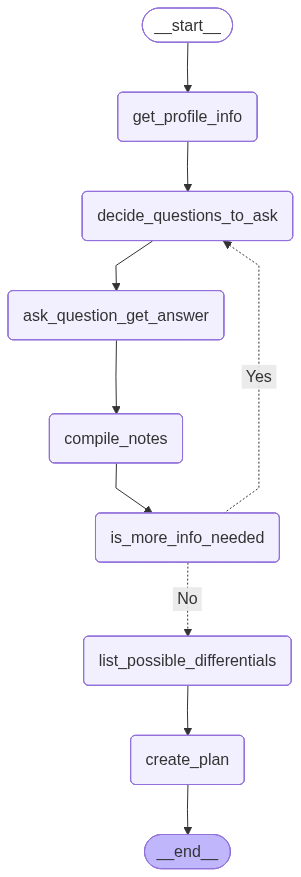

In [74]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [89]:
import streamlit as st
conversation_history = []
# conversation_history.append(HumanMessage(content="You are an expert pysician taking history from a new patient. You have to ask more questions to get full details of the illness. Gather the information systematically in a step by step fashion"))
questions = []
st.header("Thuso App")
st.subheader(f"May you please let me know what is you main concern today")
# user_input = input("Enter: ")
user_input = st.text_area("Write Answers here:", height=180)
if st.button('Submit Medical History'):
  conversation_history.append({"role":"system", "content":"You are an expert pysician taking history from a new patient. You have to ask more questions to get full details of the illness. Gather the information systematically in a step by step fashion"})

  conversation_history.append({"role":"user", "content":user_input})

  result = agent.invoke({"messages": conversation_history, "system_questions": questions, "running_notes": "","current_question":"", "patient_response":""},)
  conversation_history = result['messages']

  st.caption(f"{result}")
  # user_input = input("Enter: ")
  user_input = st.text_area("Write Answers here:", height=180)
  latest_patient_response.append(user_input)

2025-12-22 02:25:11.698 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-22 02:25:11.700 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-22 02:25:11.700 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-22 02:25:11.702 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-22 02:25:11.703 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-22 02:25:11.703 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-22 02:25:11.704 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-22 02:25:11.704 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [90]:
# from typing import TypedDict, List, Dict, Annotated, Sequence
# from  langgraph.graph import StateGraph, START, END
# import torch
# from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
# from langchain_core.tools import tool
# from langgraph.graph.message import add_messages
# from langgraph.prebuilt import ToolNode
# from transformers import pipeline
# from google.colab import userdata
# HF_TOKEN = userdata.get("HF_TOKEN")


In [91]:
!npm install localtunnel
# !npm audit fix --force

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸
up to date, audited 60 packages in 1s
⠸
⠸5 packages are looking for funding
⠸  run `npm fund` for details
⠸
6 vulnerabilities (1 low, 2 moderate, 3 high)

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠸

In [92]:
import urllib.request
print(urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip())

104.199.130.15


In [93]:
!streamlit run /content/app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

104.199.130.15
⠙your url is: https://neat-carpets-check.loca.lt


### TO-DO
1. Adjust database querries
2. Implement safety filters
3. Create good GUI
4. Display Running Conversation on screen
5. Implement and API
6. Dockerize
7. Create Tests
  a. Unit Tests with pytest
  b. Safety Tests
    i. Regex,
  c. Prompt Injection attacks
8. GitHub Actions
9. Implement RAG for referring patients, Guidelines e.g. EDLIZ, History Taking Checklist